## Работа с моделью - Создание каркаса

In [24]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region
import geopandas as gpd

In [25]:
# import osmnx as ox
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Указываем название региона
# region_name = "Ленинградская область, Россия"

# # Используем функцию geocode_to_gdf для получения границ региона
# gdf = ox.geocode_to_gdf(region_name)
# # Показываем загруженные границы
# gdf.to_file("LO_boundary.geojson", driver="GeoJSON")

## Версия 1

In [26]:
# # Создание экземпляра GraphMethod с данными
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Ленинградская область2.pickle')
# region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Тюменская область.pickle')
frame_method = PopFrame(region=region_model)

# Получение графа
G = frame_method.build_network_frame()


In [27]:
num_edges = G.number_of_edges()
print("Количество рёбер в графе:", num_edges)


Количество рёбер в графе: 2930


In [28]:
# territories = gpd.read_file('data/territories/shlis.geojson')

In [29]:
"G.nodes(data=True)"

'G.nodes(data=True)'

In [30]:
"G.edges(data=True)"

'G.edges(data=True)'

Number of agglomerations: 48


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/1247643566.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


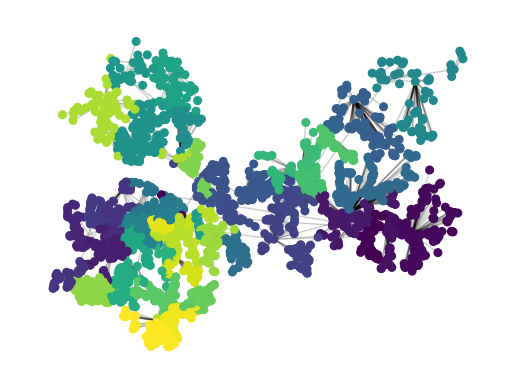

In [31]:
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def detect_agglomerations(G):
    """
    Detects agglomerations in the given graph using the Louvain algorithm.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.

    Returns:
    dict: A dictionary where keys are node indices and values are agglomeration ids.
    """
    # Apply the Louvain algorithm to detect communities
    partition = community_louvain.best_partition(G)

    return partition

def get_largest_city_name(towns_gdf, nodes):
    """
    Finds the largest city name in the given set of nodes.

    Parameters:
    towns_gdf (GeoDataFrame): The GeoDataFrame containing town information.
    nodes (list): The list of nodes in the agglomeration.

    Returns:
    str: The name of the largest city.
    """
    largest_city = towns_gdf.loc[nodes].sort_values(by='population', ascending=False).iloc[0]
    return largest_city['name']

def build_agglomeration_polygons(G, towns_gdf, partition):
    """
    Builds polygons for each agglomeration and assigns the name of the largest city.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.
    towns_gdf (GeoDataFrame): The GeoDataFrame containing town information.
    partition (dict): A dictionary where keys are node indices and values are agglomeration ids.

    Returns:
    GeoDataFrame: A GeoDataFrame with agglomeration polygons and names.
    """
    agglomerations = {}
    for node, agglomeration_id in partition.items():
        if agglomeration_id not in agglomerations:
            agglomerations[agglomeration_id] = []
        agglomerations[agglomeration_id].append(node)
    
    polygons = []
    names = []
    
    for agglomeration_id, nodes in agglomerations.items():
        points = towns_gdf.loc[nodes].geometry
        polygon = Polygon(points.unary_union.convex_hull)
        name = get_largest_city_name(towns_gdf, nodes)
        polygons.append(polygon)
        names.append(name)
    
    agglomeration_gdf = gpd.GeoDataFrame({'name': names, 'geometry': polygons}, crs=towns_gdf.crs)
    
    return agglomeration_gdf

def visualize_agglomerations(G, partition):
    """
    Visualizes agglomerations on the given graph.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.
    partition (dict): A dictionary where keys are node indices and values are agglomeration ids.
    """
    pos = nx.get_node_attributes(G, 'pos')
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.axis('off')
    plt.show()

# Пример использования:
resolution_value = 1  # Попробуйте разные значения, чтобы увидеть эффект
agglomerations = detect_agglomerations(G)
num_agglomerations = len(set(agglomerations.values()))
print(f"Number of agglomerations: {num_agglomerations}")

# Визуализируем агломерации
visualize_agglomerations(G, agglomerations)

towns_gdf = region_model.get_towns_gdf()
# Создаем полигоны агломераций и получаем GeoDataFrame
agglomeration_gdf = build_agglomeration_polygons(G, towns_gdf, agglomerations)



In [32]:
agglomeration_gdf.head()

,name,geometry
0,Бокситогорск,"POLYGON ((559251.843 6569899.852, 344150.866 6..."
1,Ефимовский,"POLYGON ((595504.175 6558530.122, 587780.067 6..."
2,Пикалево,"POLYGON ((561260.324 6560531.852, 565126.587 6..."
3,Тихвин,"POLYGON ((509498.155 6583295.013, 494715.071 6..."
4,Кингисепп,"POLYGON ((259580.719 6554980.261, 234835.969 6..."


In [33]:
agglomeration_gdf.explore()

## Версия 2


In [38]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region
import geopandas as gpd
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Ленинградская область2.pickle')
# region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Тюменская область.pickle')
frame_method = PopFrame(region=region_model)

# Получение графа
G = frame_method.build_network_frame()

Количество агломераций: 51


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/414882515.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


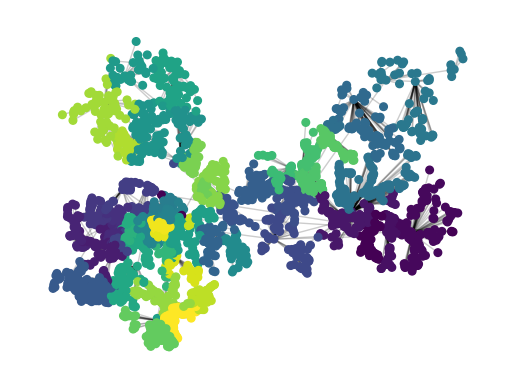

In [40]:
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, box
import numpy as np
from scipy.spatial import Voronoi
from shapely.ops import unary_union

def detect_agglomerations(G):
    # Применение алгоритма Лувена для обнаружения сообществ
    partition = community_louvain.best_partition(G)
    return partition

def get_largest_city_name(towns_gdf, nodes):
    # Нахождение названия крупнейшего города среди заданных узлов
    largest_city = towns_gdf.loc[nodes].sort_values(by='population', ascending=False).iloc[0]
    return largest_city['name']

def create_voronoi_polygons(towns_gdf, boundary_gdf):
    """
    Создает полигоны Вороного из координат городов и обрезает их по границе региона.

    Параметры:
    towns_gdf (GeoDataFrame): GeoDataFrame с информацией о городах.
    boundary_gdf (GeoDataFrame): GeoDataFrame с границами региона.

    Возвращает:
    GeoDataFrame: GeoDataFrame с обрезанными полигонами Вороного и индексами узлов.
    """
    # Получение координат городов
    points = np.array([point.coords[0] for point in towns_gdf.geometry])
    
    # Создание диаграммы Вороного
    vor = Voronoi(points)
    
    # Генерация полигонов Вороного и их обрезка по границе
    polygons = []
    node_indices = []
    
    for point_index, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            clipped_polygon = polygon.intersection(boundary_gdf.geometry.unary_union)
            if not clipped_polygon.is_empty:
                polygons.append(clipped_polygon)
                node_indices.append(point_index)
    
    return gpd.GeoDataFrame({'geometry': polygons, 'node_index': node_indices}, crs=towns_gdf.crs)

def build_agglomeration_voronoi(G, towns_gdf, boundary_gdf, partition):
    """
    Строит полигоны Вороного для каждой агломерации и присваивает имя крупнейшего города.

    Параметры:
    G (networkx.Graph): Входной граф с узлами и рёбрами.
    towns_gdf (GeoDataFrame): GeoDataFrame с информацией о городах.
    boundary_gdf (GeoDataFrame): GeoDataFrame с границами региона.
    partition (dict): Словарь, где ключи — индексы узлов, а значения — id агломераций.

    Возвращает:
    GeoDataFrame: GeoDataFrame с полигонами агломераций Вороного и именами крупнейших городов.
    """
    # Создание полигонов Вороного, обрезанных по границе региона
    voronoi_gdf = create_voronoi_polygons(towns_gdf, boundary_gdf)
    
    # Присваивание названия крупнейшего города каждому полигону Вороного
    agglomerations = {}
    for node, agglomeration_id in partition.items():
        if agglomeration_id not in agglomerations:
            agglomerations[agglomeration_id] = []
        agglomerations[agglomeration_id].append(node)
    
    polygons = []
    names = []
    
    for agglomeration_id, nodes in agglomerations.items():
        # Извлечение соответствующих полигонов для агломерации по индексу узлов
        agglomeration_polygons = voronoi_gdf[voronoi_gdf['node_index'].isin(nodes)].geometry
        if len(agglomeration_polygons) > 0:
            union_polygon = unary_union(agglomeration_polygons)
            name = get_largest_city_name(towns_gdf, nodes)
            
            polygons.append(union_polygon)
            names.append(name)
    
    agglomeration_gdf = gpd.GeoDataFrame({'name': names, 'geometry': polygons}, crs=towns_gdf.crs)
    
    return agglomeration_gdf

def visualize_agglomerations(G, partition):
    pos = nx.get_node_attributes(G, 'pos')
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.axis('off')
    plt.show()

# Пример использования:
# Предполагаем, что у вас есть граф G и towns_gdf с информацией о городах
# G = build_network_frame()  # Пример графа

towns_gdf = region_model.get_towns_gdf()
# boundary_gdf = gpd.read_file('/Users/mvin/Code/PopFrame/examples/data/tyumen_oblast_boundary.geojson')
boundary_gdf = gpd.read_file('/Users/mvin/Code/PopFrame/examples/LO_boundary.geojson')
boundary_gdf= boundary_gdf.to_crs(32636)

# Обнаруживаем агломерации
agglomerations = detect_agglomerations(G)
num_agglomerations = len(set(agglomerations.values()))
print(f"Количество агломераций: {num_agglomerations}")

# Визуализируем агломерации
visualize_agglomerations(G, agglomerations)

# Строим полигоны агломераций Вороного, обрезанные по границе региона
agglomeration_gdf = build_agglomeration_voronoi(G, towns_gdf, boundary_gdf, agglomerations)


In [41]:
agglomeration_gdf.explore()

## Версия 3

In [ ]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region
import geopandas as gpd
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Ленинградская область2.pickle')
# region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Тюменская область.pickle')
frame_method = PopFrame(region=region_model)

# Получение графа
G = frame_method.build_network_frame()

Запуск алгоритмов кластеризации...

Louvain:


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


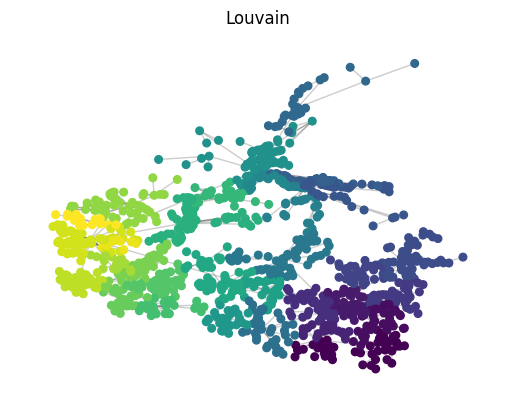


Girvan-Newman:


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


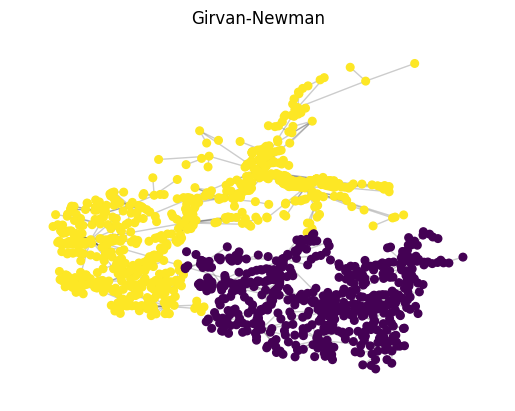


Spectral Clustering:


/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


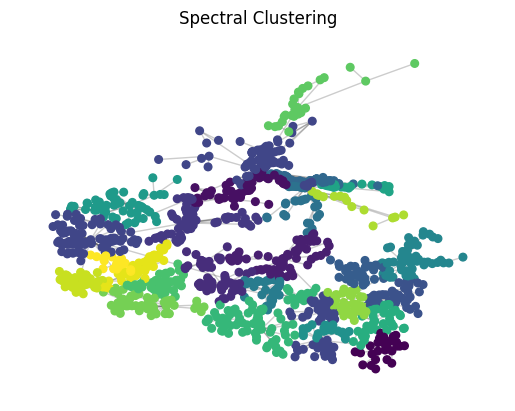

/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(



Label Propagation:


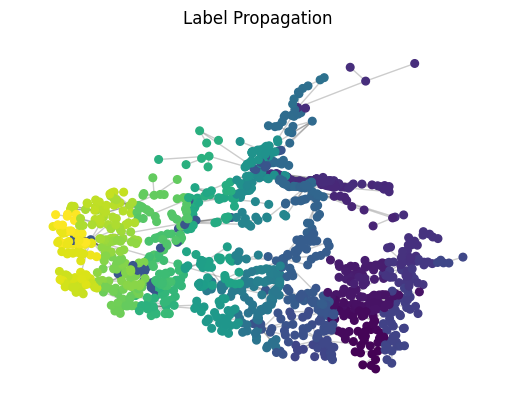


Walktrap:


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


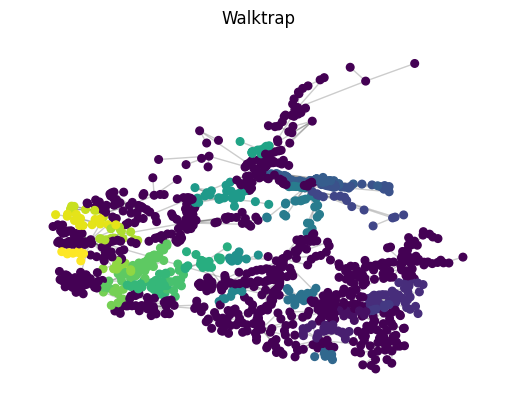


DBSCAN:


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_4510/2444742165.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


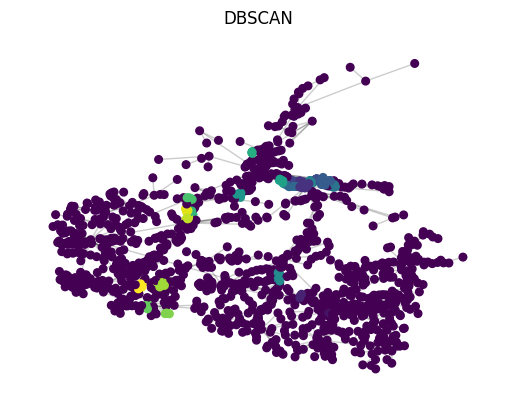

             Algorithm  Num Clusters    Silhouette Score
0              Louvain            31              0.1907
1        Girvan-Newman             2              0.4239
2  Spectral Clustering            25              0.0647
3    Label Propagation           295  Negative (-0.2768)
4             Walktrap            25  Negative (-0.3876)
5               DBSCAN            23  Negative (-0.5574)


In [ ]:
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
import igraph as ig

# Функция для визуализации кластеров
def visualize_partition(G, partition, title):
    pos = nx.get_node_attributes(G, 'pos')
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для оценки кластеризации (по координатам узлов)
def evaluate_clustering(G, partition, title):
    pos = nx.get_node_attributes(G, 'pos')
    coords = np.array([pos[node] for node in G.nodes()])
    labels = list(partition.values())
    
    num_clusters = len(set(labels))
    
    # Оценка Silhouette Score (если больше одного кластера)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(coords, labels)
        if silhouette_avg < 0:
            silhouette_avg = f"Negative ({silhouette_avg:.4f})"
        else:
            silhouette_avg = f"{silhouette_avg:.4f}"
    else:
        silhouette_avg = 'N/A'
    
    return num_clusters, silhouette_avg

# Алгоритм Лувена
def detect_louvain(G, resolution=1.0):
    partition = community_louvain.best_partition(G, resolution=resolution)
    return partition

# Алгоритм Girvan-Newman
def detect_girvan_newman(G, target_clusters=10):
    communities_generator = nx.algorithms.community.girvan_newman(G)
    for communities in communities_generator:
        if len(communities) <= target_clusters:
            break
    partition = {node: i for i, community in enumerate(communities) for node in community}
    return partition

# Спектральная кластеризация
def detect_spectral_clustering(G, num_clusters=25):
    adj_matrix = nx.to_numpy_array(G)
    embedding = SpectralEmbedding(n_components=num_clusters, affinity='precomputed').fit_transform(adj_matrix)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embedding)
    partition = {node: kmeans.labels_[i] for i, node in enumerate(G.nodes())}
    return partition

# Алгоритм распространения меток
def detect_label_propagation(G):
    communities = nx.algorithms.community.label_propagation_communities(G)
    partition = {node: i for i, community in enumerate(communities) for node in community}
    return partition

# Алгоритм Walktrap
def detect_walktrap(G, num_clusters=25):
    ig_graph = ig.Graph.from_networkx(G)
    clusters = ig_graph.community_walktrap().as_clustering(n=num_clusters)
    partition = {node: clusters.membership[i] for i, node in enumerate(G.nodes())}
    return partition

# Алгоритм DBSCAN
def detect_dbscan(G, eps=0.05, min_samples=5):
    pos = nx.get_node_attributes(G, 'pos')
    coords = np.array([pos[node] for node in G.nodes()])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    partition = {i: label for i, label in enumerate(db.labels_)}
    return partition

# Вызов всех алгоритмов с оценками и таблицей
def run_all_algorithms(G):
    print("Запуск алгоритмов кластеризации...")

    results = []

    # Лувен
    print("\nLouvain:")
    partition_louvain = detect_louvain(G, resolution=1.0)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_louvain, "Louvain")
    results.append({'Algorithm': 'Louvain', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_louvain, "Louvain")

    # Girvan-Newman
    print("\nGirvan-Newman:")
    partition_girvan_newman = detect_girvan_newman(G, target_clusters=10)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_girvan_newman, "Girvan-Newman")
    results.append({'Algorithm': 'Girvan-Newman', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_girvan_newman, "Girvan-Newman")

    # Spectral Clustering
    print("\nSpectral Clustering:")
    partition_spectral = detect_spectral_clustering(G, num_clusters=25)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_spectral, "Spectral Clustering")
    results.append({'Algorithm': 'Spectral Clustering', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_spectral, "Spectral Clustering")

    # Label Propagation
    print("\nLabel Propagation:")
    partition_label_propagation = detect_label_propagation(G)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_label_propagation, "Label Propagation")
    results.append({'Algorithm': 'Label Propagation', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_label_propagation, "Label Propagation")

    # Walktrap
    print("\nWalktrap:")
    partition_walktrap = detect_walktrap(G, num_clusters=25)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_walktrap, "Walktrap")
    results.append({'Algorithm': 'Walktrap', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_walktrap, "Walktrap")

    # DBSCAN
    print("\nDBSCAN:")
    partition_dbscan = detect_dbscan(G, eps=0.05, min_samples=5)
    num_clusters, silhouette_avg = evaluate_clustering(G, partition_dbscan, "DBSCAN")
    results.append({'Algorithm': 'DBSCAN', 'Num Clusters': num_clusters, 'Silhouette Score': silhouette_avg})
    visualize_partition(G, partition_dbscan, "DBSCAN")

    # Вывод таблицы с результатами
    df_results = pd.DataFrame(results)
    print(df_results)

# Пример добавления узлов и ребер
# G.add_node(0, pos=(33.758922, 59.36226799999999), level='Малое сельское поселение', name='Болото')
# Добавьте остальные узлы и ребра

# Запуск всех алгоритмов
run_all_algorithms(G)

## Версия 5